# KickstarterProject
Using kNN, linear regression model to predict success rate of crowdfunding.

In [140]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

## Data cleaning and processing

In [141]:
df = pd.read_csv('./data/data.csv')
df.head(1)

,Unnamed: 0,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,currency_symbol,currency_trailing_code,...,static_usd_rate,usd_pledged,usd_type,preparation_duration,preparation_duration_r,launch_duration,launch_duration_r,created_at_readable,deadline_readable,launched_at_readable
0,1,21,2006 was almost 7 years ago.... Can you believ...,Rock,802,US,1387659690,USD,$,True,...,1.0,802.0,international,351356,4d 1H 35M 56S,3888000,45d 0H 0M 0S,2013-12-21 16:01:30,2014-02-08 17:37:26,2013-12-25 17:37:26


In [142]:
df.shape

(3779, 41)

In [143]:
df.state.value_counts()

successful    2224
failed        1276
canceled       149
live           120
suspended       10
Name: state, dtype: int64

In [144]:
# drop status rows labeled as live, canceled, suspended.
df = df[~df['state'].isin(['live', 'canceled', 'suspended'])]
df.shape

(3500, 41)

In [147]:
# drop irrelevant columns.
df.drop(['Unnamed: 0', 'blurb', 'created_at', 'currency_symbol', 'currency_trailing_code', 'current_currency',
         'deadline', 'disable_communication', 'friends', 'id',
         'is_backing', 'is_starred', 'launched_at', 'state_changed_at',
         'name', 'permissions', 'profile', 'source_url', 'staff_pick', 
         'preparation_duration_r', 'launch_duration_r',
         'created_at_readable', 'deadline_readable', 'launched_at_readable', 
         'location', 'usd_type'], axis = 1, inplace = True)
df.head()

,backers_count,category,converted_pledged_amount,country,currency,fx_rate,goal,is_starrable,pledged,spotlight,state,static_usd_rate,usd_pledged,preparation_duration,launch_duration
0,21,Rock,802,US,USD,1.000000,200.0,False,802.0,True,successful,1.000000,802.000000,351356,3888000
1,97,Mixed Media,2259,US,USD,1.000000,400.0,False,2259.0,True,successful,1.000000,2259.000000,413843,1728000
2,88,Photobooks,29638,US,USD,1.000000,27224.0,False,29638.0,True,successful,1.000000,29638.000000,769946,2595600
3,193,Footwear,49158,IT,EUR,1.128433,40000.0,False,43180.0,True,successful,1.136525,49075.152523,314662,3625358
4,20,Software,549,US,USD,1.000000,1000.0,False,549.0,False,failed,1.000000,549.000000,212500,2592000


In [148]:
df['state'] = df.state.str.contains('successful').astype(int)

In [149]:
# add column representing continent
def classifier(row):
    if row.country in ['US', 'CA', 'GT', 'MX', 'PR', 'NI', 'SV', 'PA', 'BO', 'GU']:
        return 'America'
    elif row.country in ['NG', 'GH', 'ZA', 'KE', 'ET', 'CD', 'MA', 'TZ', 'ZM', 'LR', 'RW', 'ML', 'CM', 'NA', 'ZW', 'TN', 'SL', 'CF', 'UG', 'SD', 'SN', 'MW', 'MZ', 'LY', 'GN', 'SZ']:
        return 'Africa'
    elif row.country in ['GB', 'NO', 'DE', 'SE', 'BA', 'IS', 'HU', 'IT', 'NL','FR', 'UK', 'AT',
       'TR','FI', 'CZ','AM', 'PT','DK','CH', 'SJ', 'RU', 'UA', 'BG','ES','PL', 'GE','IE','GR','RS','SI','BE','GL','RO','LT', 'FM','EE','CY', 'MK','KG',]:
        return 'Europe'
    elif row.country in ['JM', 'HT','BS','DO','LC', 'DO', 'TT']:
        return 'Carribean'
    elif row.country in ['CN', 'TW', 'HK', 'NP', 'ID', 'SG', 'IN', 'JP', 'LB', 'KZ', 'KR', 'PH', 'KH', 'TH','MY','BT','LK','BM','VN','BD', 'LA','GU']:
        return 'Asia'
    elif row.country in ['IL','QA', 'AF','KZ','AE','PS','SY','SA', 'IQ','IR','TJ',]:
        return 'Arab'
    else:
        return "Oceania"   
df["continent"] = df.apply(classifier, axis=1)

In [150]:
df.head()

,backers_count,category,converted_pledged_amount,country,currency,fx_rate,goal,is_starrable,pledged,spotlight,state,static_usd_rate,usd_pledged,preparation_duration,launch_duration,continent
0,21,Rock,802,US,USD,1.000000,200.0,False,802.0,True,1,1.000000,802.000000,351356,3888000,America
1,97,Mixed Media,2259,US,USD,1.000000,400.0,False,2259.0,True,1,1.000000,2259.000000,413843,1728000,America
2,88,Photobooks,29638,US,USD,1.000000,27224.0,False,29638.0,True,1,1.000000,29638.000000,769946,2595600,America
3,193,Footwear,49158,IT,EUR,1.128433,40000.0,False,43180.0,True,1,1.136525,49075.152523,314662,3625358,Europe
4,20,Software,549,US,USD,1.000000,1000.0,False,549.0,False,0,1.000000,549.000000,212500,2592000,America


In [152]:
from sklearn import preprocessing
def encode_features(df):
    features = ['category', 'country', 'currency', 'is_starrable', 'continent', 'spotlight']
    df_combined = pd.concat([df])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df[feature] = le.transform(df[feature])
    return df
    
data = encode_features(df)
data.head()

,backers_count,category,converted_pledged_amount,country,currency,fx_rate,goal,is_starrable,pledged,spotlight,state,static_usd_rate,usd_pledged,preparation_duration,launch_duration,continent
0,21,120,802,20,13,1.000000,200.0,0,802.0,1,1,1.000000,802.000000,351356,3888000,0
1,97,83,2259,20,13,1.000000,400.0,0,2259.0,1,1,1.000000,2259.000000,413843,1728000,0
2,88,99,29638,20,13,1.000000,27224.0,0,29638.0,1,1,1.000000,29638.000000,769946,2595600,0
3,193,59,49158,12,4,1.128433,40000.0,0,43180.0,1,1,1.136525,49075.152523,314662,3625358,2
4,20,126,549,20,13,1.000000,1000.0,0,549.0,0,0,1.000000,549.000000,212500,2592000,0


In [153]:
df.continent.value_counts()

0    2677
2     689
3      98
1      36
Name: continent, dtype: int64

In [174]:
X = df.drop(['preparation_duration', 'launch_duration'], axis=1)
y = df['state']

In [175]:
from sklearn.preprocessing import Imputer
X = Imputer().fit_transform(X)

## kNN model

In [181]:
k_range = range(1,200)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring = 'accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.9957085363962154, 0.9939958740187966, 0.993705257069154, 0.9925648419287387, 0.9922766763110602, 0.9914211614555455, 0.9919868780269928, 0.9917044290740569, 0.9914178961227673, 0.9905623812672524, 0.990275848315963, 0.9902774809823519, 0.9902774809823521, 0.9891362471763617, 0.988563181273783, 0.9879933807039825, 0.988563181273783, 0.9882815463216609, 0.9882799136552718, 0.9885672652721365, 0.9877109317510463, 0.9871394985148566, 0.9868545982299564, 0.9868545982299566, 0.9859982647088664, 0.9854260174718629, 0.9848570309028762, 0.9851411171869625, 0.9842831509994834, 0.9842839696650586, 0.9831411078574401, 0.9825688606204365, 0.9825696699564894, 0.9822831416699612, 0.9825704886220643, 0.98199987405145, 0.9811402751975817, 0.9817133411001604, 0.980283946341253, 0.981141093863157, 0.9808537469110534, 0.9808537469110536, 0.980282313674864, 0.9799957807235744, 0.9797092477722851, 0.9797092477722851, 0.978851281584806, 0.9791378145360954, 0.9791370005352814, 0.9791378145360954, 0.9788512

In [182]:
scores.mean()

0.9745696186441173

In [183]:
scores.max()

0.9857549857549858

Text(0,0.5,'cross-validated accuracy')

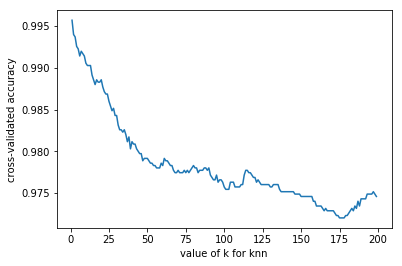

In [184]:
plt.plot(k_range, k_scores)
plt.xlabel('value of k for knn')
plt.ylabel('cross-validated accuracy')

In [185]:
MSE = [1 - x for x in k_scores]
optimal_k = k_range[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 1
